In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import os
import scanpy as sc
%matplotlib inline

In [7]:
###### read in this tsv .to_csv('/data/tbaharav/umi_dyla
# n/umi_analysis/umi_probs_length_5.tsv', sep='\t', header=False, index=False)
umi_probs = pd.read_csv('/data/tbaharav/umi_dylan/umi_analysis/umi_probs_length_5.tsv', sep='\t', header=None)
umi_probs.columns = ['umi', 'prob']

In [8]:
umi_prob_arr = np.array(umi_probs['prob'])


In [9]:
umi_probs

,umi,prob
0,TTTTT,0.004044
1,CTTTT,0.002864
2,ATTTT,0.002794
3,TTTAT,0.002710
4,TTTTA,0.002665
...,...,...
1019,GGAGG,0.000396
1020,GAGCG,0.000384
1021,GGAGA,0.000379
1022,GGGAG,0.000375


### UMI 4 

In [9]:
from collections import OrderedDict
# Truncate UMIs from length 5 to length 4
umi_probs['umi_4'] = umi_probs['umi'].str[:-1]

# Accumulate probabilities while preserving first occurrence order
umi_sum_dict = OrderedDict()

for idx, row in umi_probs.iterrows():
    umi = row['umi_4']
    prob = row['prob']
    if umi in umi_sum_dict:
        umi_sum_dict[umi] += prob
    else:
        umi_sum_dict[umi] = prob

# Create the new ordered DataFrame
umi_probs_length_4 = pd.DataFrame({
    'umi': list(umi_sum_dict.keys()),
    'prob': list(umi_sum_dict.values())
})

# (Optional) save for your pipeline consistency
umi_probs_length_4.to_csv('/data/dagyeman/cellranger/bam_file_analysis/umi_probs_length_4.tsv', sep='\t', index=False, header=False)

# Quick inspection
print(umi_probs_length_4.head())

    umi      prob
0  TTTT  0.011668
1  CTTT  0.008506
2  ATTT  0.008227
3  TTTA  0.008100
4  TCTT  0.007775


##### Load the dataframe 

In [13]:
umi_probs_length_4 = pd.read_csv('/data/dagyeman/cellranger/bam_file_analysis/umi_probs_length_4.tsv', sep='\t', header=None)
umi_probs_length_4.columns = ['umi', 'prob']

In [14]:
umi_prob_arr = np.array(umi_probs_length_4['prob'])

In [5]:
######## forward model for computing expected number of collided UMIs given true n_umis, and an empirical distribution of UMI probabilities
def compute_non_unif_estimator(umi_prob_arr, n_umis_true,K):
    """
    Compute the estimator for non-collided UMI counts.
    
    Parameters:
    umi_prob_arr (numpy.ndarray): Array of UMI probabilities.
    n_umis_true (int): True number of UMIs.
    K (int): Total number of UMIs.
    """
    
    assert len(umi_prob_arr) == K, "Length of umi_prob_arr must be equal to K"
    # assert n_umis_true <= K, "n_umis_true must be less than or equal to K"
    
    # Compute the expected number of UMIs from collisions
    
    return K - np.sum( (1-umi_prob_arr)**n_umis_true )
    
    
def compute_naive_unif_estimator(n_umis_true, K):
    """
    Compute the naive estimator for non-collided UMI counts.
    """
    return K * (1 - (1 - 1 / K)**n_umis_true)

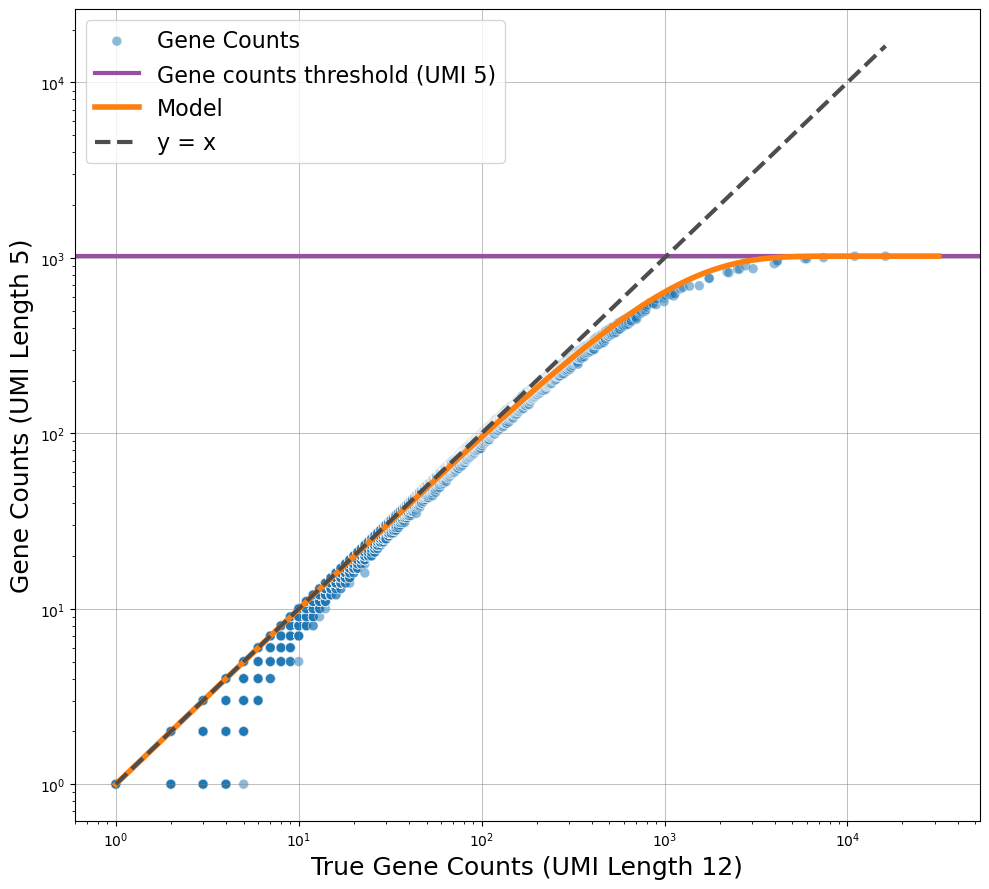

In [19]:
###### Dylan initial plotting code

# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"  # Directory for 1k_PBMCs



directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/"  # Directory for 10k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/"  # Directory for 10k_PBMCs


# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/"  # Directory for 5k PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ur_objects/adata_matrices/"  # Directory for 5k PBMCs


# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ub_objects/adata_matrices/"  # Directory for 500 PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ur_objects/adata_matrices/"  # Directory for 500 PBMCs



# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/"  # Directory for 5k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ur_objects/adata_matrices/"  # Directory for 5k_PBMCs

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    

# Fully remove MALAT1 from adata_dict[5] and adata_dict[12] before plotting
for k in [5, 12]:
    if "MALAT1" in adata_dict[k].var_names:
        adata_dict[k] = adata_dict[k][:, adata_dict[k].var_names != "MALAT1"].copy()





# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Fixed comparison UMI length
# barcode = "TGTATCTCAGGAATCT-1" # 5k PBMCs 
# barcode = "CAGCAGCTCTCCAATT-1" # 500 PBMCs
n_values = np.logspace(0, 4.5, 200)

min_ct_threshold = 1

# Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/counts_plots/naive"
# os.makedirs(save_dir, exist_ok=True)

# Find the barcode index
# index_i = np.where(adata_dict[i].obs_names == barcode)[0][0]
# index_j = np.where(adata_dict[j].obs_names == barcode)[0][0]

# # Extract and process counts
# gene_counts_i = adata_dict[i].X[index_i].flatten()
# gene_counts_j = adata_dict[j].X[index_j].flatten()

gene_counts_i = adata_dict[i].X.flatten()
gene_counts_j = adata_dict[j].X.flatten()

mask = gene_counts_i >= min_ct_threshold
gene_counts_i = gene_counts_i[mask]
gene_counts_j = gene_counts_j[mask]

sorted_idx = np.argsort(gene_counts_i)
sorted_gene_counts_i = gene_counts_i[sorted_idx] #+ 1
sorted_gene_counts_j = gene_counts_j[sorted_idx] #+ 1

# Create plot
plt.figure(figsize=(10, 9))

# Compute colors based on condition
colors = ["red" if sorted_gene_counts_j[i] - f(sorted_gene_counts_j[i], j) < -40 else '#1f77b4' for i in range(len(sorted_gene_counts_i)) ]


plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j, alpha=0.5, 
            c=colors, edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')

y_asymptotic_value = 4**j
plt.axhline(y=y_asymptotic_value, color='#984ea3', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')

model_vals = f(n_values, j)
plt.plot(n_values, model_vals, color='#ff7f0e', linewidth=4, label='Model')

######### also plot results from compute_non_unif_estimator
# K = 4**j
# non_unif_prediction = [compute_non_unif_estimator(umi_prob_arr, n, K) for n in n_values]
# plt.plot(n_values, non_unif_prediction, color='#2ca02c', linewidth=4, label='Non-uniform estimator')



max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_i.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Gene Counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(fontsize=16, loc = "upper left")
plt.tight_layout()

plt.show()



#### Identifying the points 

In [20]:
import pandas as pd

# Filter points where the difference is < -40
filtered_indices = [i for i in range(len(sorted_gene_counts_i)) if sorted_gene_counts_j[i] - f(sorted_gene_counts_i[i], j) < -55]

# Create a DataFrame with the filtered counts
filtered_data = pd.DataFrame({
    'sorted_gene_counts_i': sorted_gene_counts_i[filtered_indices],
    'sorted_gene_counts_j': sorted_gene_counts_j[filtered_indices],
    'difference': sorted_gene_counts_j[filtered_indices] - f(sorted_gene_counts_i[filtered_indices], j)
})

print(filtered_data)

    sorted_gene_counts_i  sorted_gene_counts_j  difference
0                  703.0                 447.0  -61.770242
1                  900.0                 541.0  -57.980044
2                  995.0                 563.0  -73.654385
3                 1124.0                 607.0  -75.523371
4                 1140.0                 623.0  -64.820042
5                 1371.0                 690.0  -65.741666
6                 1550.0                 694.0 -104.783908
7                 1748.0                 767.0  -71.397646
8                 1759.0                 764.0  -76.381715
9                 2198.0                 831.0  -73.425613
10                2248.0                 823.0  -87.126671
11                2510.0                 862.0  -73.844501
12                2567.0                 862.0  -78.619787
13                2778.0                 901.0  -55.152966
14                3052.0                 868.0 -104.088165
15                3988.0                 925.0  -78.1982

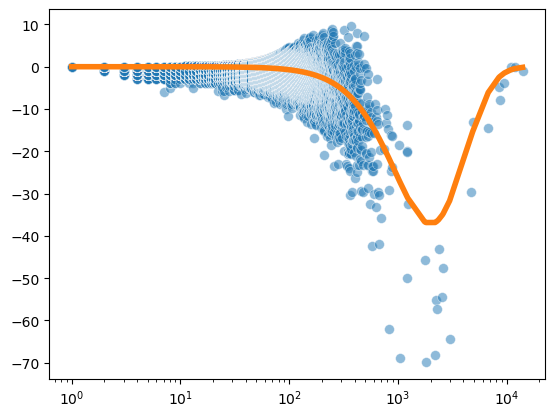

In [17]:
###### center plot by subtracting model_vals
K = 4**j
plt.figure()
naive_pred = f(sorted_gene_counts_i,j)
opt_pred = np.array([compute_non_unif_estimator(umi_prob_arr, n, K) for n in sorted_gene_counts_i])
# plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
#            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')
# plt.plot(sorted_gene_counts_i, naive_pred - opt_pred, color='#ff7f0e', linewidth=4, label='uniform minus non-uniform predictions')

plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - naive_pred, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts - Naive')
plt.plot(sorted_gene_counts_i, opt_pred-naive_pred, color='#ff7f0e', linewidth=4, label='non_uniform minus naive predictions')


plt.xscale('log')


In [ ]:
# ###### center by subtracting model_vals
# plt.figure()
# naive_pred = f(sorted_gene_counts_i,j)
# opt_pred = np.array([compute_non_unif_estimator(umi_prob_arr, n, K) for n in sorted_gene_counts_i])
# # plt.scatter(sorted_gesne_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
# #             c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')
# # plt.plot(sorted_gene_counts_i, naive_pred - opt_pred, color='#ff7f0e', linewidth=4, label='uniform minus non-uniform predictions')

# plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - naive_pred, alpha=0.5, 
#             c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts - Naive')
# plt.plot(sorted_gene_counts_i, opt_pred-naive_pred, color='#ff7f0e', linewidth=4, label='non_uniform minus naive predictions')


# plt.xscale('log')


#### Coloring for those that are below -40 

In [21]:
###### center plot by subtracting model_vals
K = 4**j
plt.figure()
naive_pred = f(sorted_gene_counts_i, j)
opt_pred = np.array([compute_non_unif_estimator(umi_prob_arr, n, K) for n in sorted_gene_counts_i])

# Compute y-values for scatter plot
y_values = sorted_gene_counts_j - naive_pred

# Set color based on condition
colors = ['red' if y < -40 else '#1f77b4' for y in y_values]

plt.scatter(sorted_gene_counts_i, y_values, alpha=0.5, 
            c=colors, edgecolors='w', s=50, linewidth=0.5, label='Gene Counts - Naive')
plt.plot(sorted_gene_counts_i, opt_pred - naive_pred, color='#ff7f0e', linewidth=4, label='non_uniform minus naive predictions')

plt.xscale('log')
plt.legend(loc ='upper left')

### Figuring out the points 

In [12]:
import pysam
import pandas as pd

# Path to the filtered BAM file
filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/filtered_500_PBMCS_bam.bam' # filtered path for 1k dataset 
# filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/filtered_10k_PBMCS_bam.bam' # filtered bam path for 10k dataset

# List to store rows of data (barcode, gene, UMI)
data = []

# Open the filtered BAM file for reading
with pysam.AlignmentFile(filtered_bam_path, "rb") as bam_file:
    # Iterate over each read in the BAM file
    for read in bam_file:
        # Check if the read has 'CB' (cell barcode), 'GN' (gene name), and 'UB' (UMI) tags
        if read.has_tag('CB') and read.has_tag('GN') and read.has_tag('UB'):
            # Extract the 'CB' (cell barcode), 'GN' (gene name), and 'UB' (UMI) tags
            barcode = read.get_tag('CB')
            gene = read.get_tag('GN')
            umi = read.get_tag('UB')
            
            # Append the row to the data list
            data.append([barcode, gene, umi])

# Convert the list into a pandas DataFrame
df = pd.DataFrame(data, columns=['barcode', 'gene', 'UMI'])


# Filter out UMIs that contain 'N'
df = df[~df['UMI'].str.contains('N')]


# Show the first few rows of the DataFrame
print(df.head())
    

              barcode        gene           UMI
0  TATTGCTTCCGAGAAG-1  AL627309.1  CATATTACAGGT
1  TATTGCTTCCGAGAAG-1  AL627309.1  CATATTACAGGT
2  TTACAGGCATCCTATT-1  AL627309.1  CAATCGTATCTT
3  GTGTGGCAGGAACTCG-1  AL627309.1  TAATACACTCTT
4  TGTCCTGTCCCAACTC-1  AL627309.1  ATCTTCGGGCTT


In [13]:
# Loop through shortened UMI lengths from 1 to 12
for k in range(1, 13):
    # Shorten the 'UMI' to the first 'k' bases
    df[f'UMI_{k}'] = df.UMI.str[:k]
    
    # Group by 'barcode' and 'gene' and count the number of unique shortened UMIs for each combination
    grouped_df = df.groupby(['barcode', 'gene'])[f'UMI_{k}'].nunique().reset_index()
    
    # Rename the column to reflect that it's counting unique UMIs of length 'k'
    grouped_df.rename(columns={f'UMI_{k}': f'unique_UMI_count_{k}'}, inplace=True)
    
    # Optionally, you can store the resulting DataFrame for each 'k' or print the first few rows
    print(f"Unique UMI counts for UMI length {k}:")
    print(grouped_df.head())

# Example: To merge results across different lengths (optional)
# Merging results for all k values across lengths 1-12 into one DataFrame (if needed)
final_df = df.groupby(['barcode', 'gene']).agg({f'UMI_{k}': 'nunique' for k in range(1, 13)}).reset_index()

# Rename the columns accordingly to reflect the unique UMI counts for each length
final_df.columns = ['barcode', 'gene'] + [f'unique_UMI_count_{k}' for k in range(1, 13)]

# Show the first few rows of the final merged DataFrame
print(final_df.head())

Unique UMI counts for UMI length 1:
              barcode      gene  unique_UMI_count_1
0  AATCACGAGGATCACG-1      AAAS                   1
1  AATCACGAGGATCACG-1      AAK1                   3
2  AATCACGAGGATCACG-1      AARS                   1
3  AATCACGAGGATCACG-1     AASDH                   1
4  AATCACGAGGATCACG-1  AASDHPPT                   1
Unique UMI counts for UMI length 2:
              barcode      gene  unique_UMI_count_2
0  AATCACGAGGATCACG-1      AAAS                   1
1  AATCACGAGGATCACG-1      AAK1                   4
2  AATCACGAGGATCACG-1      AARS                   1
3  AATCACGAGGATCACG-1     AASDH                   1
4  AATCACGAGGATCACG-1  AASDHPPT                   1
Unique UMI counts for UMI length 3:
              barcode      gene  unique_UMI_count_3
0  AATCACGAGGATCACG-1      AAAS                   1
1  AATCACGAGGATCACG-1      AAK1                   4
2  AATCACGAGGATCACG-1      AARS                   1
3  AATCACGAGGATCACG-1     AASDH                   1
4  AATCA

In [14]:
# 1) Create the 12-base UMI and drop true technical duplicates on the *full* UMI
df['UMI_12'] = df['UMI'].str[:12]
dedup_df    = df[['barcode','gene','UMI_12']].drop_duplicates()

# 2) Count UMI_12 per cell–gene
counts_df = (
    dedup_df
    .groupby(['barcode','gene'])['UMI_12']
    .nunique()
    .reset_index(name='count_12')
)

# 3) Now *separately* deduplicate and count the 5-base UMIs
dedup_5 = (
    dedup_df
    .assign(UMI_5=dedup_df['UMI_12'].str[:5])
    .drop_duplicates(subset=['barcode','gene','UMI_5'])
)
count_5_df = (
    dedup_5
    .groupby(['barcode','gene'])['UMI_5']
    .count()
    .reset_index(name='count_5')
)

# Merge the two counts
counts_df = counts_df.merge(count_5_df, on=['barcode','gene'])

# 4) Filter for your specified (count_12, count_5) pairs
target_counts = [
    (493, 336),
    (586, 402),
    (593, 409),
    (622, 426),
    (630, 418),
    (689, 434),
    (733, 472),
    (764, 496),
    (930, 545),
    (988, 593),
    (2558, 860),
]
target_counts_set = set(target_counts)

eligible_pairs = counts_df[
    counts_df[['count_12', 'count_5']].apply(tuple, axis=1).isin(target_counts_set)
].reset_index(drop=True)

# 5) Inspect
print(f"Found {len(eligible_pairs)} cell–gene pairs matching the specified count_12 and count_5 values.\n")
print(eligible_pairs.head())

Found 11 cell–gene pairs matching the specified count_12 and count_5 values.

              barcode    gene  count_12  count_5
0  AGACACTGTTACACAC-1  S100A9       930      545
1  ATGAGTCAGCTCTGTA-1  S100A9       493      336
2  ATGAGTCCATATCTGG-1     FTL       630      418
3  ATGAGTCGTTCGGCTG-1   IGHA1       733      472
4  ATGAGTCGTTCGGCTG-1    IGKC      2558      860


In [15]:
eligible_pairs

,barcode,gene,count_12,count_5
0,AGACACTGTTACACAC-1,S100A9,930,545
1,ATGAGTCAGCTCTGTA-1,S100A9,493,336
2,ATGAGTCCATATCTGG-1,FTL,630,418
3,ATGAGTCGTTCGGCTG-1,IGHA1,733,472
4,ATGAGTCGTTCGGCTG-1,IGKC,2558,860
5,ATGAGTCTCATGCCCT-1,S100A9,988,593
6,CAGCGTGAGTAGTCTC-1,S100A9,593,409
7,GGTAACTTCGAACGCC-1,S100A9,764,496
8,TGGTACAGTCCTTAAG-1,S100A9,689,434
9,TTACAGGCATCCTATT-1,S100A9,622,426


### 10k data points identification 

In [ ]:


directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/"  # Directory for 10k_PBMCs

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    
adata_5 = adata_dict[5]
adata_12 = adata_dict[12]

import pandas as pd
import numpy as np

# Your count pairs
count_pairs = [
    (703, 447),
    (900, 541),
    (995, 563),
    (1124, 607),
    (1140, 623),
    (1371, 690),
    (1550, 694),
    (1748, 767),
    (1759, 764),
    (2198, 831),
    (2248, 823),
    (2510, 862),
    (2567, 862),
    (2778, 901),
    (3052, 868),
    (3988, 925),
    (4106, 946)
]

# Extract X matrices as dense arrays for fast filtering
X_12 = adata_12.X.toarray() if not isinstance(adata_12.X, np.ndarray) else adata_12.X
X_5 = adata_5.X.toarray() if not isinstance(adata_5.X, np.ndarray) else adata_5.X

# Create DataFrames for easy indexing
df_12 = pd.DataFrame(X_12, index=adata_12.obs_names, columns=adata_12.var_names)
df_5 = pd.DataFrame(X_5, index=adata_5.obs_names, columns=adata_5.var_names)

results = []

# Loop through each count pair efficiently
for c12, c5 in count_pairs:
    # Find locations in adata_12 matching c12
    idx_12, gene_idx_12 = np.where(df_12.values == c12)
    for i, j in zip(idx_12, gene_idx_12):
        cell = df_12.index[i]
        gene = df_12.columns[j]
        # Confirm matching value in adata_5
        if df_5.loc[cell, gene] == c5:
            results.append({
                "barcode": cell,
                "gene": gene,
                "count_12": c12,
                "count_5": c5
            })

# Convert to DataFrame for clear output
results_df = pd.DataFrame(results)


# Optionally, print for immediate viewing
print(results_df)


In [ ]:
############# validate that non-uniform model accurately predicts results when data is generated from this model


umi_probs_12 = pd.read_csv('/data/tbaharav/umi_dylan/umi_analysis/umi_counts_overall.tsv', sep='\t', header=None)
umi_probs_12.columns = ['umi', 'counts']
umi_probs_12['prob'] = umi_probs_12['counts'] / umi_probs_12['counts'].sum()


In [9]:
######### generate a fake dataset:

def gen_synthetic_gene(umi_probs, n_umis_true, k=5):
    """
    Generate a synthetic gene expression dataset based on UMI probabilities.
    
    Parameters:
    umi_probs (pd.DataFrame): DataFrame containing UMI probabilities.
    n_umis_true (int): True number of UMIs.
    k (int): Length of UMIs to consider.
    
    Returns:
    pd.DataFrame: Synthetic gene expression dataset.
    """
    
    # Generate random UMIs based on the given probabilities
    umis = np.random.choice(umi_probs['umi'], size=n_umis_true, p=umi_probs['counts']/umi_probs['counts'].sum())
    
    length_12_counts = len(np.unique(umis))
    k = 5  # or set k as a function argument if you want it flexible
    truncated_umis = [umi[:k] for umi in umis]
    length_k_counts = len(np.unique(truncated_umis))
    
    return length_12_counts, length_k_counts
    


In [45]:
from tqdm import tqdm

np.random.seed(0)
# n_true_to_use = np.arange(1, 1000, 10)
n_true_to_use = np.logspace(0, np.log10(40000), 200, dtype=int)
####### add lots of points in logspace between n_extra_min and n_extra_max
n_extra_min = 90
n_extra_max = 6000
n_extra = np.logspace(np.log10(n_extra_min), np.log10(n_extra_max), 100, dtype=int)

### more extra points
n_extra_2 = np.logspace(np.log10(800), np.log10(4000), 200, dtype=int)

n_true_to_use = np.concatenate((n_true_to_use, n_extra, n_extra_2))

n_true_to_use = np.unique(n_true_to_use)
## sort
n_true_to_use = np.sort(n_true_to_use)

k=5
K=4**k

length_12_counts = []
length_k_counts = []
unif_estimator = []
non_unif_estimator = []

for n_umis_true in tqdm(n_true_to_use):
    len_12_ct, len_k_ct = gen_synthetic_gene(umi_probs_12, n_umis_true, k)
    length_12_counts.append(len_12_ct)
    length_k_counts.append(len_k_ct)
    unif_estimator.append(compute_naive_unif_estimator(n_umis_true, K))
    non_unif_estimator.append(compute_non_unif_estimator(umi_prob_arr, n_umis_true, K))
# Convert to numpy arrays
length_12_counts = np.array(length_12_counts)
length_k_counts = np.array(length_k_counts)
unif_estimator = np.array(unif_estimator)
non_unif_estimator = np.array(non_unif_estimator)


100%|██████████| 445/445 [00:41<00:00, 10.73it/s]


In [46]:
(length_12_counts-n_true_to_use)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   -1,    0,    0,    0,    0,    0,
          0,   -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   -1,    0,    0,    0,    0,   

/tmp/ipykernel_2748609/3546742822.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothed[i] = x_point @ coeffs
/tmp/ipykernel_2748609/3546742822.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothed[i] = x_point @ coeffs
/tmp/ipykernel_2748609/3546742822.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothed[i] = x_point @ coeffs
/tmp/ipykernel_2748609/3546742822.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Text(0, 0.5, 'Collided Gene Counts (UMI Length 5) - Uniform Estimator')

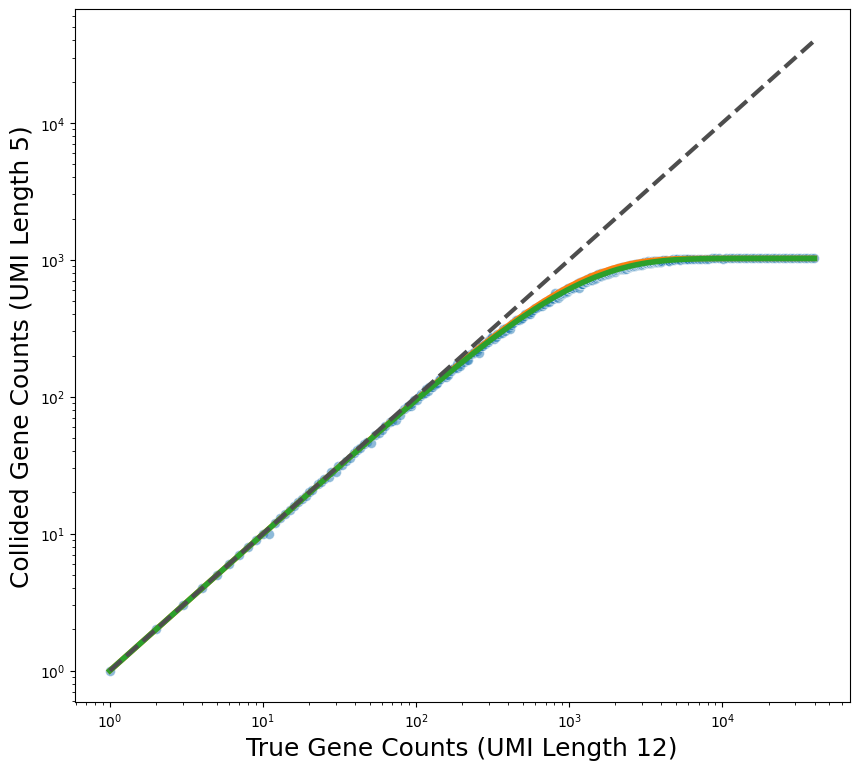

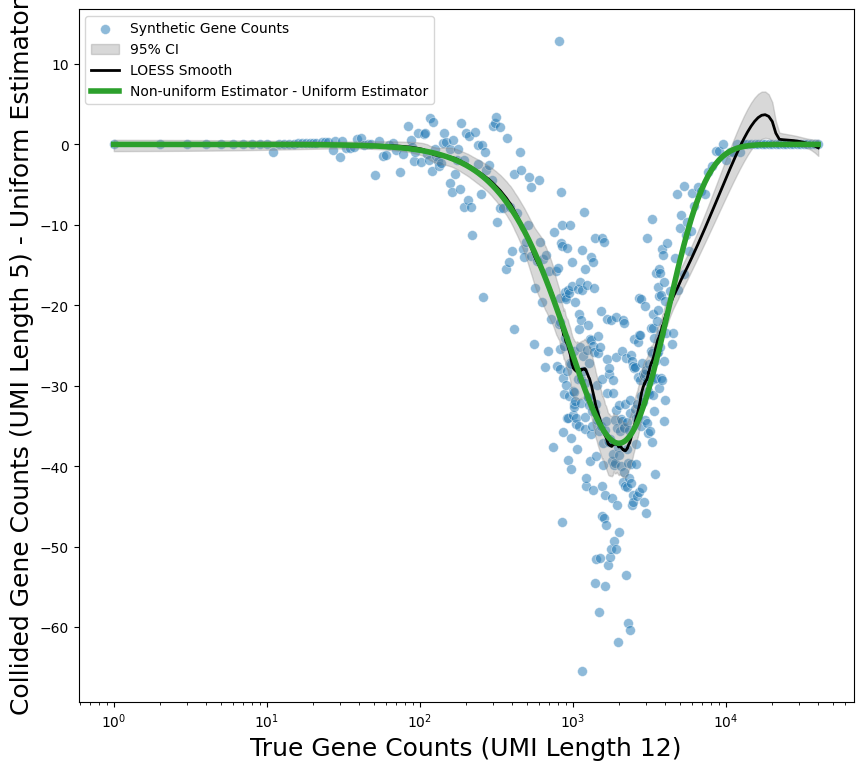

In [50]:
#### plot all
plt.figure(figsize=(10, 9))
# data
plt.scatter(length_12_counts, length_k_counts, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Synthetic Gene Counts')
### unif model
plt.plot(length_12_counts, unif_estimator, color='#ff7f0e', linewidth=4, label='Uniform Estimator')
### non-unif model
plt.plot(length_12_counts, non_unif_estimator, color='#2ca02c', linewidth=4, label='Non-uniform Estimator')
### y=x line
plt.plot([1, length_12_counts.max()], [1, length_12_counts.max()], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Collided Gene Counts (UMI Length {k})', fontsize=18)




##### plot differences, subtract the "uniform prediction" from everything
plt.figure(figsize=(10, 9))
plt.scatter(length_12_counts, length_k_counts - unif_estimator, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Synthetic Gene Counts')


# Usage
x_smooth, y_smooth, ci_low, ci_high = loess_smooth(
    n_true_to_use, 
    length_k_counts - unif_estimator, 
    degree=2,
    frac=0.2
)

plt.fill_between(x_smooth, ci_low, ci_high, alpha=0.3, color='gray', label='95% CI')
plt.plot(x_smooth, y_smooth, color='black', linewidth=2, label='LOESS Smooth')

# # Compute and plot moving average (window size = 7, can adjust)
# window = 15
# if len(n_true_to_use) >= window:
#     # Sort by n_true_to_use just in case
#     sort_idx = np.argsort(n_true_to_use)
#     x_sorted = n_true_to_use[sort_idx]
#     y_sorted = (length_k_counts - unif_estimator)[sort_idx]
#     y_ma = np.convolve(y_sorted, np.ones(window)/window, mode='valid')
#     x_ma = x_sorted[(window//2):-(window//2)] if window % 2 == 1 else x_sorted[(window//2-1):-(window//2)]
#     plt.plot(x_ma, y_ma, color='black', linewidth=2, label=f'Moving Avg (window={window})')
plt.plot(length_12_counts, non_unif_estimator - unif_estimator, color='#2ca02c', linewidth=4, label='Non-uniform Estimator - Uniform Estimator')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Collided Gene Counts (UMI Length {k}) - Uniform Estimator', fontsize=18)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd

def loess_smooth(x, y, frac=0.3, degree=1, return_ci=True, alpha=0.05):
    """
    LOESS smoothing with optional confidence intervals
    
    Parameters:
    - frac: fraction of data to use for each local regression
    - degree: polynomial degree (1=linear, 2=quadratic)
    - return_ci: whether to compute confidence intervals
    - alpha: significance level for CI (0.05 = 95% CI)
    """
    # Sort data
    sort_idx = np.argsort(x)
    x_sorted, y_sorted = x[sort_idx], y[sort_idx]
    
    n = len(x_sorted)
    smoothed = np.zeros(n)
    if return_ci:
        ci_lower = np.zeros(n)
        ci_upper = np.zeros(n)
    
    # LOESS smoothing
    for i in range(n):
        # Define local neighborhood
        h = int(np.ceil(frac * n))
        start = max(0, i - h//2)
        end = min(n, start + h)
        if end - start < h:
            start = max(0, end - h)
        
        # Local regression
        x_local = x_sorted[start:end]
        y_local = y_sorted[start:end]
        
        # Weights (tricube kernel)
        distances = np.abs(x_local - x_sorted[i])
        max_dist = np.max(distances)
        if max_dist > 0:
            weights = (1 - (distances / max_dist)**3)**3
            weights[distances > max_dist] = 0
        else:
            weights = np.ones(len(x_local))
        
        # Weighted polynomial regression
        if degree == 1:
            X = np.column_stack([np.ones(len(x_local)), x_local])
        else:
            poly = PolynomialFeatures(degree=degree)
            X = poly.fit_transform(x_local.reshape(-1, 1))
        
        # Weighted least squares
        W = np.diag(weights)
        try:
            coeffs = np.linalg.solve(X.T @ W @ X, X.T @ W @ y_local)
            if degree == 1:
                smoothed[i] = coeffs[0] + coeffs[1] * x_sorted[i]
            else:
                x_point = poly.transform(x_sorted[i].reshape(-1, 1))
                smoothed[i] = x_point @ coeffs
            
            # Confidence intervals
            if return_ci:
                residuals = y_local - X @ coeffs
                mse = np.sum(weights * residuals**2) / np.sum(weights)
                if degree == 1:
                    x_design = np.array([1, x_sorted[i]])
                else:
                    x_design = x_point.flatten()
                
                var_pred = mse * x_design.T @ np.linalg.inv(X.T @ W @ X) @ x_design
                t_val = stats.t.ppf(1 - alpha/2, len(x_local) - degree - 1)
                margin = t_val * np.sqrt(var_pred)
                ci_lower[i] = smoothed[i] - margin
                ci_upper[i] = smoothed[i] + margin
                
        except np.linalg.LinAlgError:
            smoothed[i] = np.average(y_local, weights=weights)
            if return_ci:
                ci_lower[i] = ci_upper[i] = smoothed[i]
    
    if return_ci:
        return x_sorted, smoothed, ci_lower, ci_upper
    return x_sorted, smoothed
